# 1. Introduction

In [1]:
from gensim.models import Word2Vec
import gensim.downloader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import json
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize

## 1.1 Testing Words Definition
*Prepare the testing words*
- Semantically related
  - Countries: USA, Canada, Brazil, UK, France, Germany, Italy, Spain, Russia, China, India, Japan, Australia, Mexico, Egypt, South Africa, Nigeria, Kenya
  - Professions: Doctor, Engineer, Teacher, Lawyer, Nurse, Architect, Dentist, Pharmacist, Accountant, Psychologist, Veterinarian, Chef, Pilot, Journalist, Librarian, Electrician, Plumber, Carpenter
  - Aynonyms and Synonyms: Good, Bad, Happy, Sad, Smart, Stupid, Strong, Weak, Fast, Slow, Big, Small, Tall, Short, Old, Young, Rich, Poor, Beautiful, Ugly
- Syntactically related
  - Prepositions: in, on, at, by, for, with, of, to, from, through, between, among, under, over, above, below, near, far, around, about
  - Conjunctions: and, or, but, so, because, although, however, therefore, meanwhile, nevertheless, otherwise, instead
  - Verbs and Past Tense: run, ran, walk, walked, jump, jumped, eat, ate, drink, drank, sleep, slept, read, read, write, wrote, sing, sang, dance, danced

In [68]:
# load TestWordsSemanticAndSyntactic.json
with open('TestWordsSemanticAndSyntactic.json', 'r') as f:
	testWords = json.load(f)
semantically_related = testWords["Semantically"]
syntactically_related = testWords["Syntactically"]

testWords_countries = semantically_related["Countries"]
testWords_professions = semantically_related["Professions"]
testWords_antonyms_and_synonyms = semantically_related["Aynonyms_and_Synonyms"]
testWords_prepositions = syntactically_related["Prepositions"]
testWords_conjunctions = syntactically_related["Conjunctions"]
testWords_verbs_and_past_tense = syntactically_related["Verbs_and_Past_Tense"]

testWords_semantic = testWords_countries + testWords_professions + testWords_antonyms_and_synonyms
print(testWords_semantic)

testWords_syntactic = testWords_prepositions + testWords_conjunctions + testWords_verbs_and_past_tense
print(testWords_syntactic)

['USA', 'Canada', 'Brazil', 'UK', 'France', 'Germany', 'Italy', 'Spain', 'Russia', 'China', 'India', 'Japan', 'Australia', 'Mexico', 'Egypt', 'South Africa', 'Nigeria', 'Kenya', 'Doctor', 'Engineer', 'Teacher', 'Lawyer', 'Nurse', 'Architect', 'Dentist', 'Pharmacist', 'Accountant', 'Psychologist', 'Veterinarian', 'Chef', 'Pilot', 'Journalist', 'Librarian', 'Electrician', 'Plumber', 'Carpenter', 'Good', 'Bad', 'Happy', 'Sad', 'Smart', 'Stupid', 'Strong', 'Weak', 'Fast', 'Slow', 'Big', 'Small', 'Tall', 'Short', 'Old', 'Young', 'Rich', 'Poor', 'Beautiful', 'Ugly']
['in', 'on', 'at', 'by', 'for', 'with', 'of', 'to', 'from', 'through', 'between', 'among', 'under', 'over', 'above', 'below', 'near', 'far', 'around', 'about', 'and', 'or', 'but', 'so', 'because', 'although', 'however', 'therefore', 'meanwhile', 'nevertheless', 'otherwise', 'instead', 'run', 'ran', 'walk', 'walked', 'jump', 'jumped', 'eat', 'ate', 'drink', 'drank', 'sleep', 'slept', 'read', 'read', 'write', 'wrote', 'sing', 'sang

## 1.2 Tool function definition
- PCA_2D_plot: This function is used to calculate the PCA 2D plot of the testing words vector from any model and the vectors of the testing words

In [63]:
def PCA_2D_plot(model, testing_words, title):
	'''
	This function is used to calculate the PCA 2D plot of the testing words vector from any model and the vectors of the testing words
	:param model: a keyedVectors model
	:param testing_words: a list of testing words
	:param title: a string of the title of the plot
	:return:
	'''
	# transform the testing words into vectors using the model
	vectors = {}
	for word in testing_words:
		word = word.lower()
		if word in model:
			vectors[word] = model[word]
	
	# if vectors is empty, return
	if len(vectors) == 0:
		print("No words in the model")
		return

	# create a list to store the vectors
	# The shape of the list is (number of words, number of dimensions)
	X = []
	for key in vectors:
		X.append(vectors[key])

	# fit the vectors into PCA model
	# The shape of the result is (number of words, 2)
	# Which is the first two dimensions of the result of PCA
	pca = PCA(n_components=2)
	result = pca.fit_transform(X)

	# plot the vectors in 2D using matplotlib and annotate the words
	# make the annotation font size bigger
	plt.figure(figsize=(24, 8))
	plt.title(title)
	plt.scatter(result[:, 0], result[:, 1])
	words = list(vectors.keys())
	for i, word in enumerate(words):
		plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=16)

	plt.show()

# 2. Building and Analyzing Word Vectors with Word2Vec
- Task: Create word vectors using the Word2Vec model on a selected corpus.
- Visualization: Utilize PCA or t-SNE for visualizing these vectors in 2D.
- Analysis: Discuss the word relationships and clusters formed.
## 2.1 Building a custom Word2Vec model
- The corpus is a public domain book, Alice's Adventures in Wonderland by Lewis Carroll
- link: https://www.gutenberg.org/files/11/11-0.txt


In [57]:
# load the file from the URL directly
import urllib.request
url = "https://www.gutenberg.org/files/11/11-0.txt"
file = urllib.request.urlopen(url)

# read the file and decode it into a string
longString = file.read().decode("utf8")

# Data Preprocessing
# Replaces escape character with space
cleanedString = longString.replace("\n", " ")

data = []

# Split the whole string into sentences using sent_tokenize() method from nltk
# then split the sentence into words using word_tokenize() method from nltk
sentences = sent_tokenize(cleanedString)
for i in sentences:
	temp = []
	words = word_tokenize(i)
	for j in words:
		temp.append(j.lower())
	data.append(temp)
	
print("Total number of words in the data: ", sum([len(i) for i in data]))

Total number of words in the data:  38090


### 2.1.1 Train a CBOW word2vec model
- CBOW model is used to predict the current word given the context
	- min_count: is the minimum frequency of words required to create the model
	- vector_size: is the dimension of the word vectors
	- window: is the maximum distance between the current and predicted word within a sentence

In [67]:
# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count=1, vector_size=100, window=5)
model1.wv.save("myword2vec.model")
model1 = gensim.models.KeyedVectors.load("myword2vec.model")

In [71]:
# I picked some words frome Alice's Adventures in Wonderland to visualize the word vectors by PCA in 2D,
# Since if I use my own words, the word vectors may not be trained well
custom_testWords_Original = """
It was high time to go, for the pool was getting quite crowded with the
birds and animals that had fallen into it: there were a Duck and a
Dodo, a Lory and an Eaglet, and several other curious creatures. Alice
led the way, and the whole party swam to the shore.
"""

# split it to words
custom_testWords = word_tokenize(custom_testWords_Original.lower())

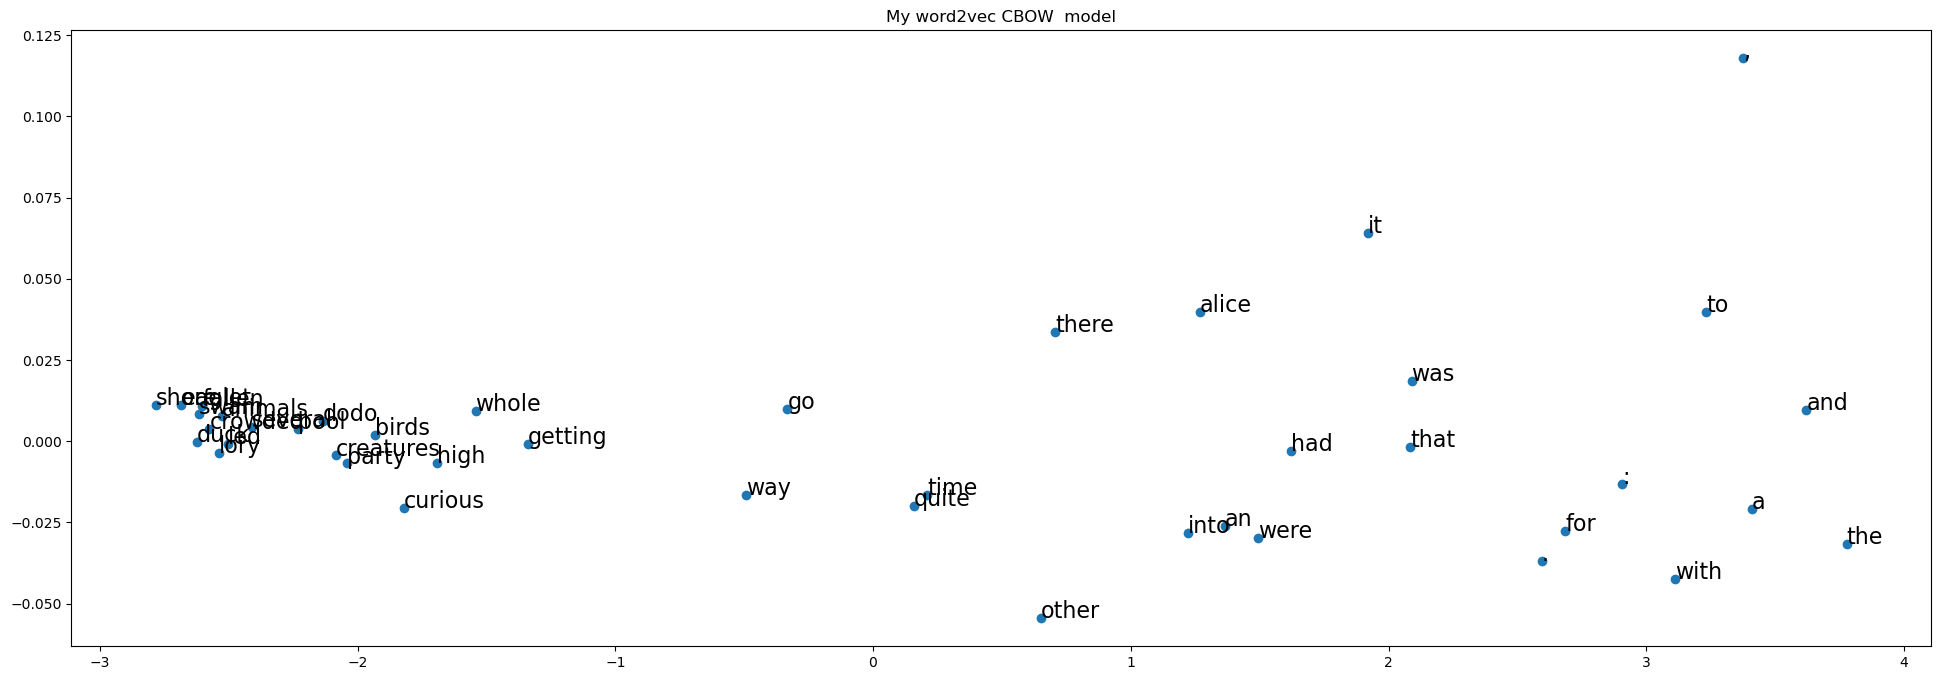

In [73]:
# Test different kinds of words
PCA_2D_plot(model1, custom_testWords, "My word2vec CBOW  model")

### 2.1.2 Train a Skip-gram word2vec model
- Skip-gram model is used to predict the context given the current word
	- min_count: is the minimum frequency of words required to create the model
	- vector_size: is the dimension of the word vectors
	- window: is the maximum distance between the current and predicted word within a sentence
	- sg: is the training algorithm, 1 for skip-gram, 0 for CBOW

In [69]:
model2 = gensim.models.Word2Vec(data, min_count=1, vector_size=100, window=5, sg=1)
model2.wv.save("myword2vec_SkipGram.model")
model2 = gensim.models.KeyedVectors.load("myword2vec_SkipGram.model")

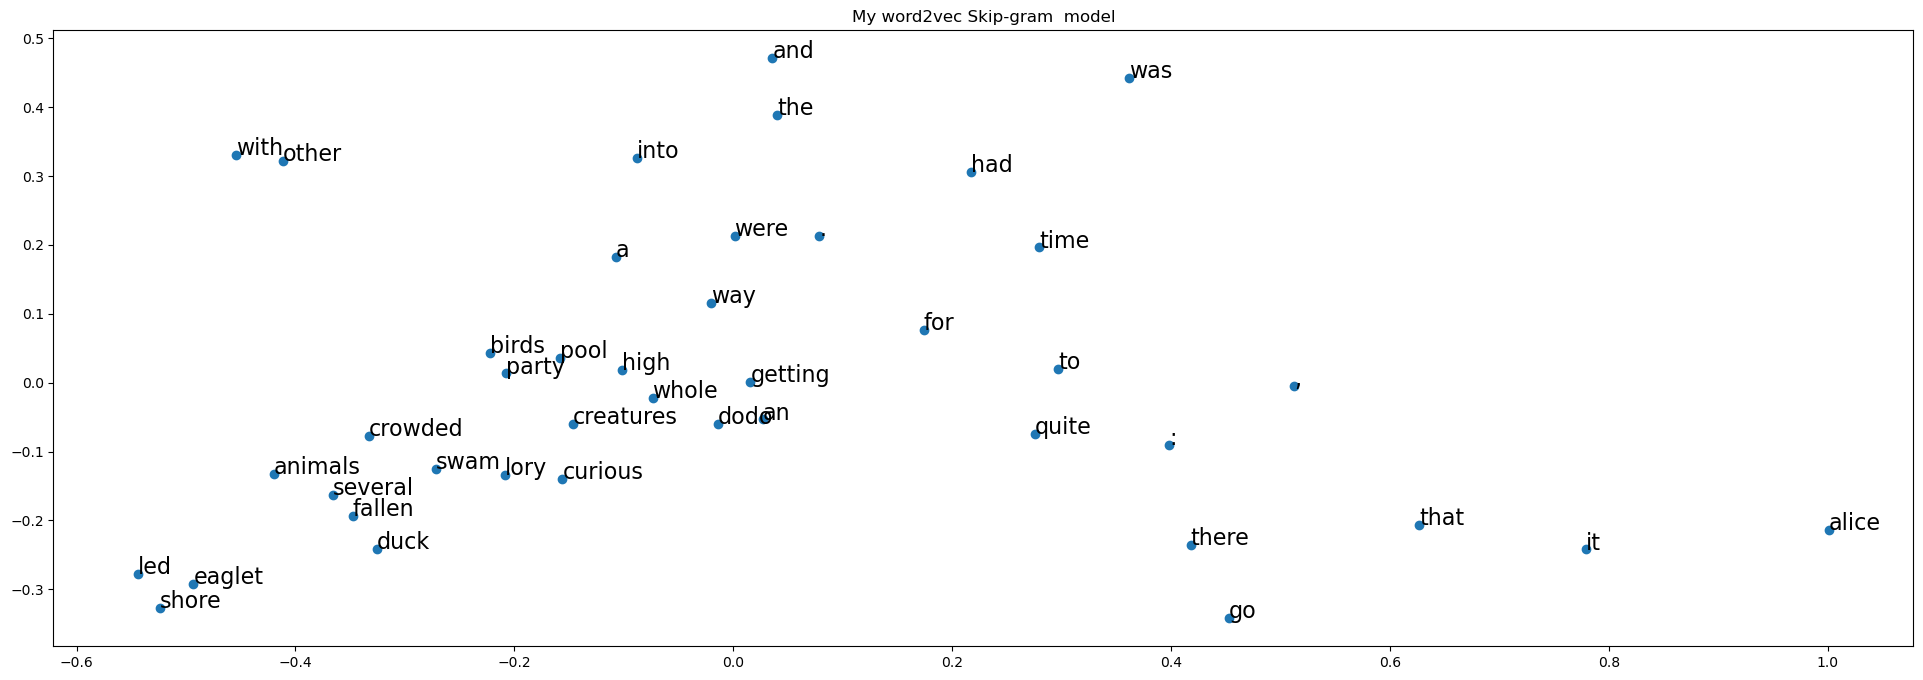

In [75]:
# Test different kinds of words
PCA_2D_plot(model2, custom_testWords, "My word2vec Skip-gram  model")

## 2.2 Useing the pre-trained word2vector models
- Download from gensim-data

In [76]:
# Show all available models in gensim-data
pre_train_models = list(gensim.downloader.info()['models'].keys())
print(pre_train_models)

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


#### 2.2.1 I chose "word2vec-google-news-300"

In [31]:
# download the "word2vec-google-news-300" embeddings
word2vec_Google_news_vectors = gensim.downloader.load('word2vec-google-news-300')
# save the model
word2vec_Google_news_vectors.save("word2vec-google-news-300.model")

*A quick test*

In [77]:
word2vec_Google_news_vectors.most_similar('queen')

[('queens', 0.739944338798523),
 ('princess', 0.7070532441139221),
 ('king', 0.6510956883430481),
 ('monarch', 0.6383602023124695),
 ('very_pampered_McElhatton', 0.6357026696205139),
 ('Queen', 0.6163407564163208),
 ('NYC_anglophiles_aflutter', 0.6060680150985718),
 ('Queen_Consort', 0.5923796892166138),
 ('princesses', 0.5908074975013733),
 ('royal', 0.5637185573577881)]

#### 2.2.2 PCA visualize my testing word vectors in 2D
- using the pre-trained word2vec model "word2vec-google-news-300" to generate the word vectors
- then use PCA to visualize the word vectors in 2D

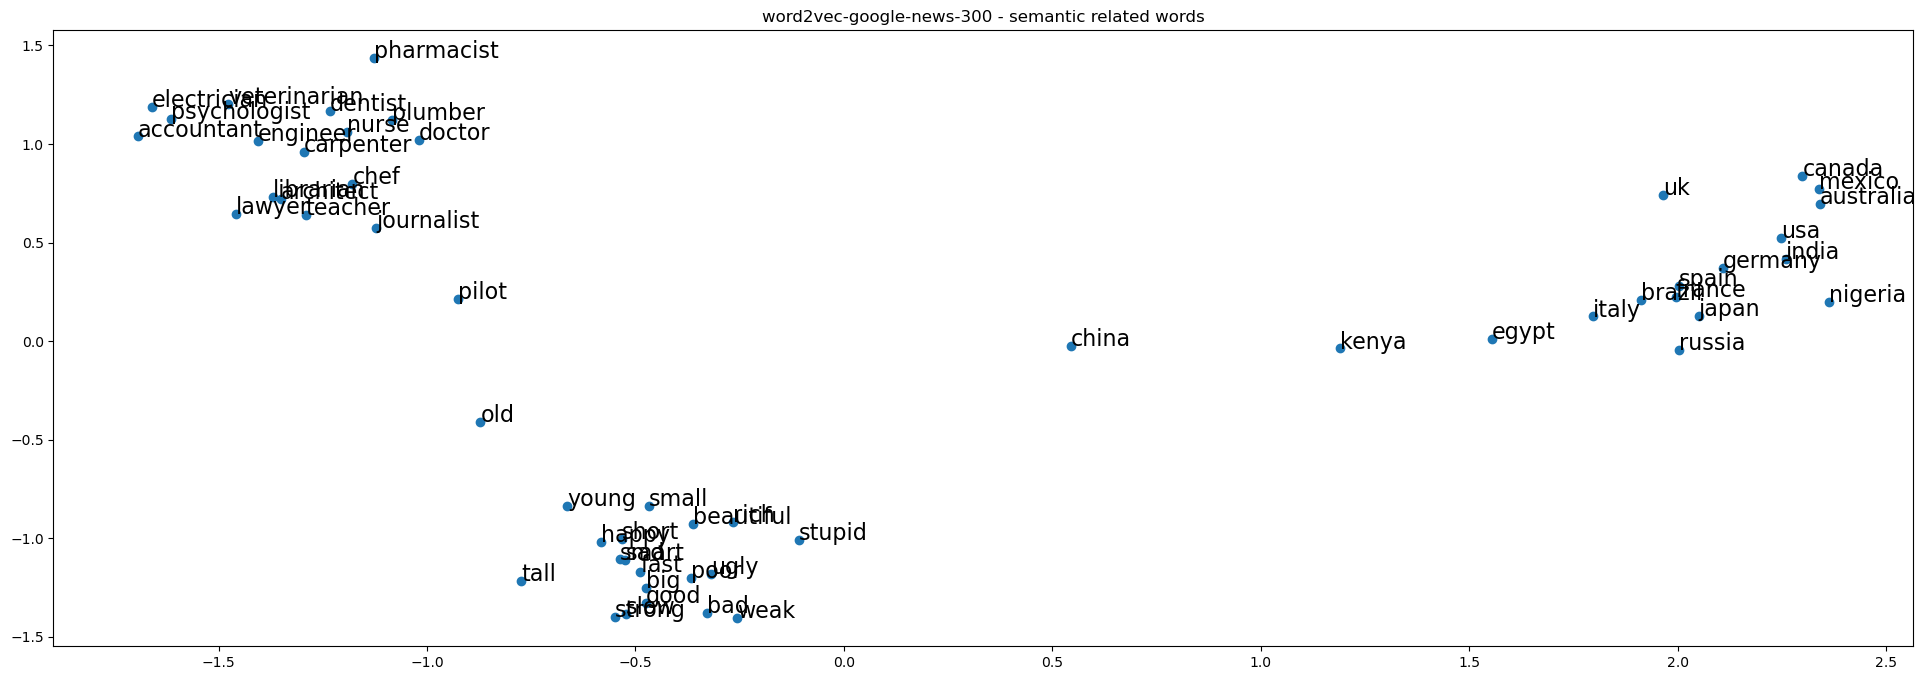

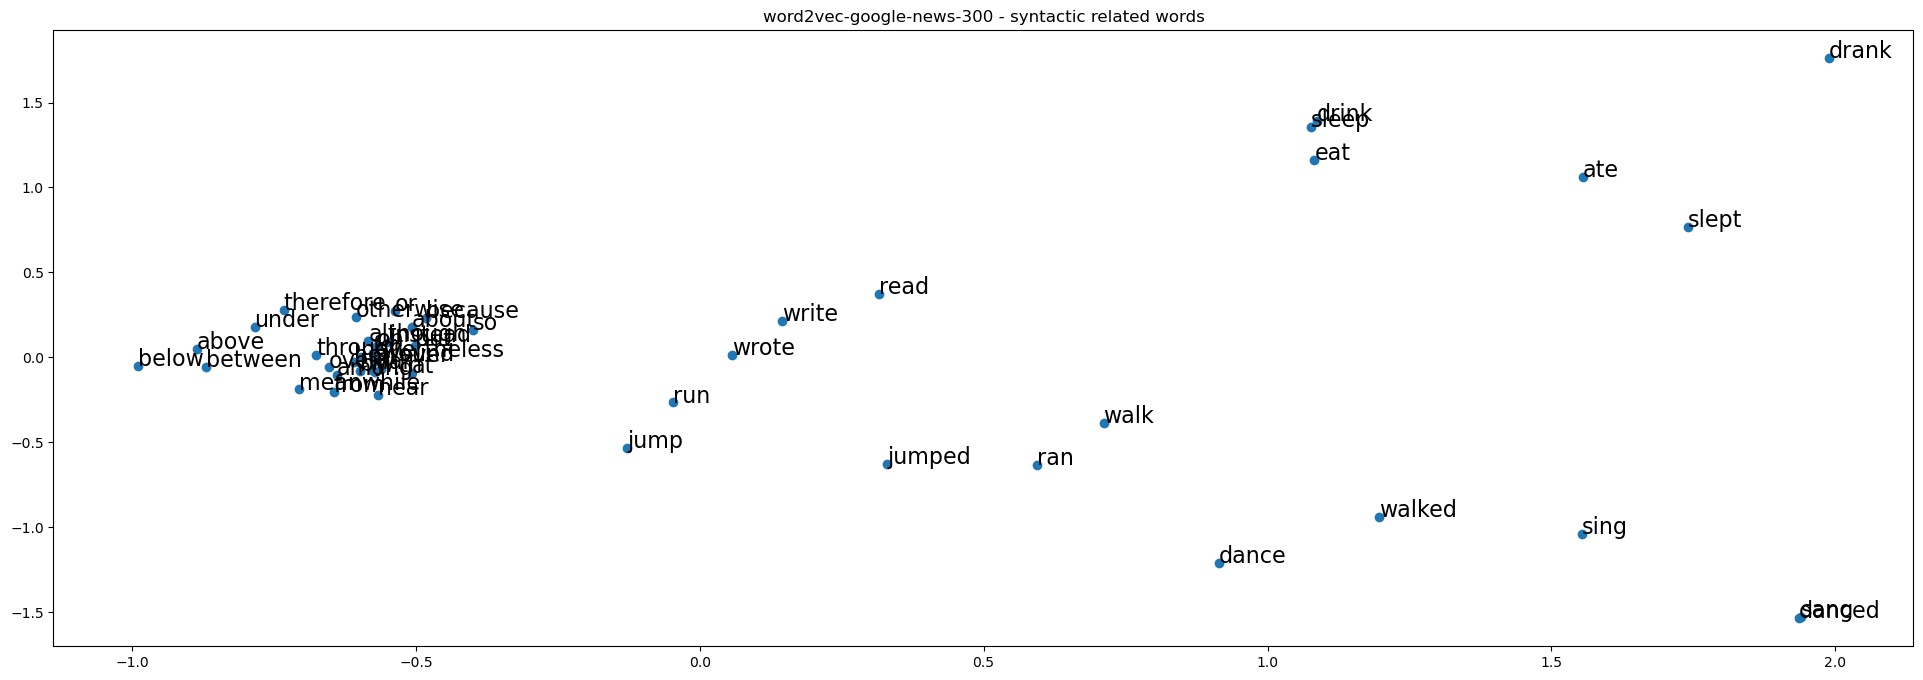

In [78]:
# Test different kinds of words
PCA_2D_plot(word2vec_Google_news_vectors, testWords_semantic, "word2vec-google-news-300 - semantic related words")

PCA_2D_plot(word2vec_Google_news_vectors, testWords_syntactic, "word2vec-google-news-300 - syntactic related words")

# 3. GloVe Vectors Advanced Analysis
- Task: Analyze word relationships using pre-trained GloVe vectors.
- Activity: Conduct an analogy task (e.g., king - man + woman = ?) with examples.
- Explanation: Explain the results of the analogy tasks.

### 3.1 Using the pre-trained GloVe vectors
- The pre-trained GloVe vectors are available in gensim-data
- the pre-trained GloVe model "glove-wiki-gigaword-300" is used

In [16]:
# download the "glove-wiki-gigaword-300" embeddings
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
# save the model
glove_vectors.save("glove-wiki-gigaword-300.model")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [81]:
# A quick test
glove_vectors.most_similar('dog')

[('dogs', 0.7888557314872742),
 ('cat', 0.6816746592521667),
 ('pet', 0.6291598081588745),
 ('puppy', 0.593606173992157),
 ('hound', 0.5468214750289917),
 ('horse', 0.5369751453399658),
 ('animal', 0.5316445827484131),
 ('cats', 0.5080744028091431),
 ('canine', 0.5038436055183411),
 ('pets', 0.5019966959953308)]

### 3.2 Conduct an analogy task
- calculate this king - man + woman, and see if the result is similar to queen

In [45]:
# calculate the vector of the analogy task
vector_after_calculation = glove_vectors["king"] - glove_vectors["man"] + glove_vectors["woman"]

# find the most similar word to the vector_after_calculation
result = glove_vectors.similar_by_vector(vector_after_calculation)
print("The most similar word to the vector_after_calculation is: ", result)

The most similar word to the vector_after_calculation is:  [('king', 0.8859834671020508), ('queen', 0.8609582185745239), ('daughter', 0.7684512734413147), ('prince', 0.7640699744224548), ('throne', 0.7634970545768738), ('princess', 0.7512729167938232), ('elizabeth', 0.7506489157676697), ('father', 0.7314497232437134), ('kingdom', 0.7296158671379089), ('mother', 0.728001058101654)]


### 3.3 PCA visualize my testing word vectors in 2D

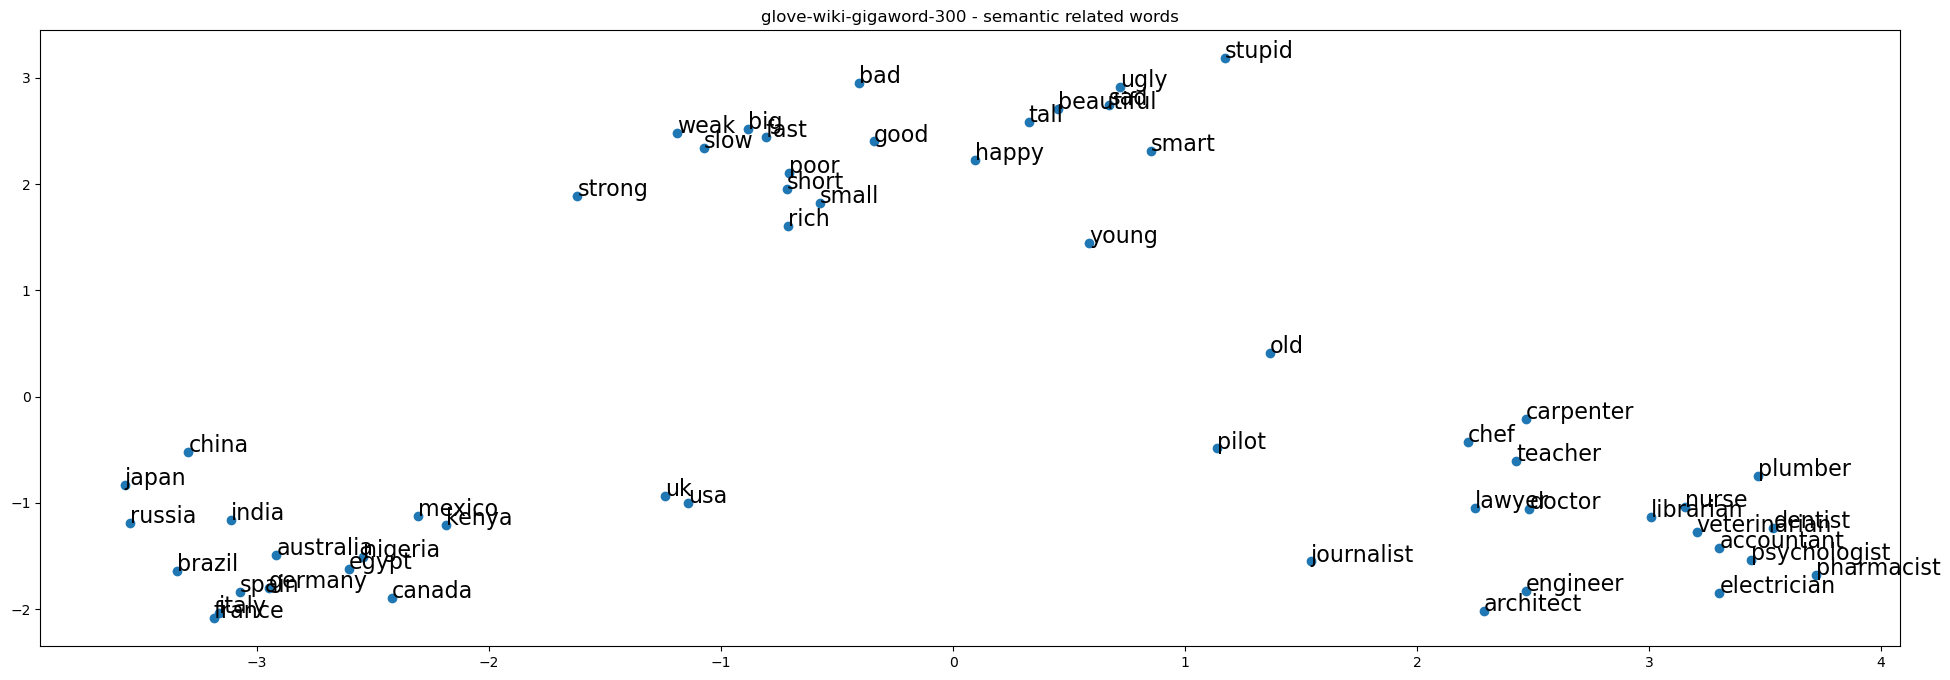

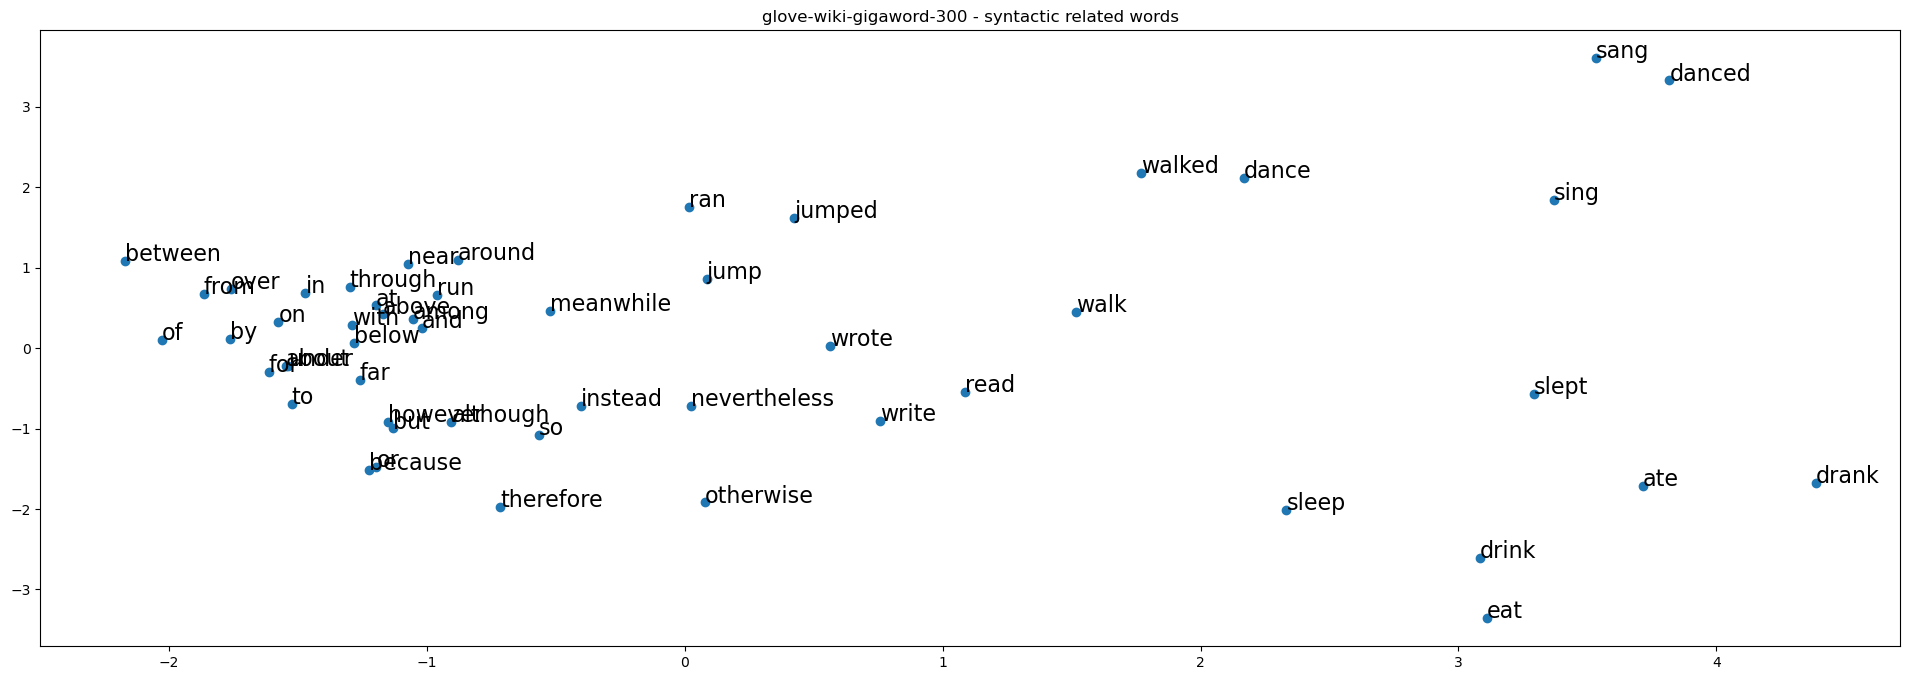

In [80]:
# Test different kinds of words
PCA_2D_plot(glove_vectors, testWords_semantic, "glove-wiki-gigaword-300 - semantic related words")

PCA_2D_plot(glove_vectors, testWords_syntactic, "glove-wiki-gigaword-300 - syntactic related words")

# 4. Comparison of Word2Vec and GloVe through examples
Here I chose some word pairs:
- Semantic relationship: 
  - Happy - Sad, Good - Bad, Strong - Weak, Big - Small, Rich - Poor
- Syntactic relationship:
  - in - on, run - ran, walk - walked, but - so

In [86]:
# function to calculate the similarity
def similarity(word1, word2, model):
	'''
	This function is used to calculate the similarity between two words using word2vec and glove
	:param word1: a string of the first word
	:param word2: a string of the second word
	:param model: a word2vec or glove model
	:return: a float of the similarity
	'''
	word1 = word1.lower()
	word2 = word2.lower()
	return model.similarity(word1, word2)

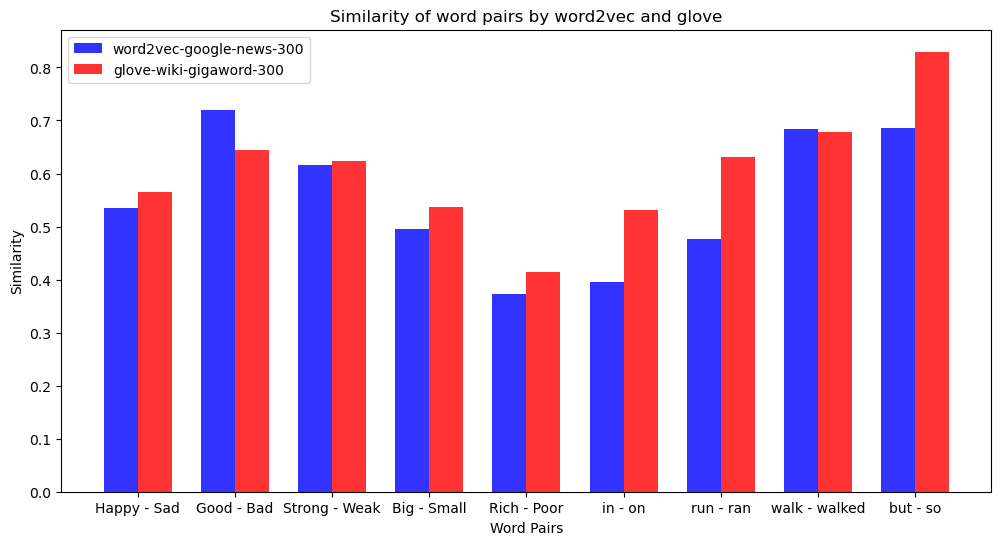

In [96]:
# Test the similarity of the word pairs
word_pairs = [
	["Happy", "Sad"],
	["Good", "Bad"],
	["Strong", "Weak"],
	["Big", "Small"],
	["Rich", "Poor"],
	["in", "on"],
	["run", "ran"],
	["walk", "walked"],
	["but", "so"]
]

# calculate the similarity of the word pairs by the two models
# plot the result
word2vec_google_news_300_similarity = []
glove_wiki_gigaword_300_similarity = []
for pair in word_pairs:
	word1 = pair[0]
	word2 = pair[1]
	word2vec_google_news_300_similarity.append(similarity(word1, word2, word2vec_Google_news_vectors))
	glove_wiki_gigaword_300_similarity.append(similarity(word1, word2, glove_vectors))

# plot the result group by the word pairs and the models in a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
index = range(len(word_pairs))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, word2vec_google_news_300_similarity, bar_width, alpha=opacity, color='b', label='word2vec-google-news-300')
rects2 = plt.bar([i + bar_width for i in index], glove_wiki_gigaword_300_similarity, bar_width, alpha=opacity, color='r', label='glove-wiki-gigaword-300')

plt.xlabel('Word Pairs')
plt.ylabel('Similarity')
plt.title('Similarity of word pairs by word2vec and glove')
plt.xticks([i + bar_width / 2 for i in index], [f"{pair[0]} - {pair[1]}" for pair in word_pairs])
plt.legend()

# plt.tight_layout()
plt.show()